In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("real_time_sensor_data.csv", names=["engine_temp", "battery_voltage", "fuel_pressure", "oil_temp", "engine_load"])

print("Dataset Shape:", df.shape)
print("Columns:", df.columns)
df.head()

Dataset Shape: (3360, 5)
Columns: Index(['engine_temp', 'battery_voltage', 'fuel_pressure', 'oil_temp',
       'engine_load'],
      dtype='object')


,engine_temp,battery_voltage,fuel_pressure,oil_temp,engine_load
0,113.58,12.05,38.38,115.27,67.57
1,101.47,12.26,47.59,104.84,57.23
2,78.58,12.72,33.74,131.49,58.41
3,86.87,14.12,32.86,102.95,22.56
4,86.03,12.44,47.13,118.65,26.16


In [2]:
df['failure_status'] = 0  # Default to no failure

# Define failure conditions based on sensor readings
df.loc[df['engine_temp'] > 110, 'failure_status'] = 1
df.loc[df['battery_voltage'] < 11, 'failure_status'] = 1
df.loc[df['fuel_pressure'] < 30, 'failure_status'] = 1
df.loc[df['oil_temp'] > 130, 'failure_status'] = 1
df.loc[df['engine_load'] > 90, 'failure_status'] = 1

# Check the failure distribution
print(df['failure_status'].value_counts())


failure_status
0    1958
1    1402
Name: count, dtype: int64


In [5]:
#from sklearn.ensemble import IsolationForest

#iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Assume 5% failures
#df['failure_status'] = iso_forest.fit_predict(df[['engine_temp', 'battery_voltage', 'fuel_pressure', 'oil_temp', 'engine_load']])

# Convert IsolationForest labels (-1 means anomaly/failure)
#df['failure_status'] = df['failure_status'].apply(lambda x: 1 if x == -1 else 0)

# Check distribution of failures
#print(df['failure_status'].value_counts())


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['failure_status'])  
y = df['failure_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
# Normalize for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train multiple models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    acc = accuracy_score(y_test, y_pred)  # Evaluate accuracy
    
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.8229
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       392
           1       0.82      0.74      0.78       280

    accuracy                           0.82       672
   macro avg       0.82      0.81      0.82       672
weighted avg       0.82      0.82      0.82       672

Random Forest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       392
           1       1.00      1.00      1.00       280

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672



C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:30:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       392
           1       1.00      1.00      1.00       280

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672



In [37]:
!pip install xgboost==3.0.0

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)


In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Random Forest model with Cross-Validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5)
print("Random Forest Cross-Validation scores:", rf_cv_scores)
print("Average Cross-Validation score:", np.mean(rf_cv_scores))

# XGBoost model with Cross-Validation
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5)
print("XGBoost Cross-Validation scores:", xgb_cv_scores)
print("Average Cross-Validation score:", np.mean(xgb_cv_scores))


Random Forest Cross-Validation scores: [0.9985119 0.9985119 1.        1.        1.       ]
Average Cross-Validation score: 0.9994047619047619
XGBoost Cross-Validation scores: [0.99553571 0.9985119  0.99702381 0.99702381 0.99404762]
Average Cross-Validation score: 0.9964285714285716


In [15]:
from sklearn.metrics import accuracy_score

# Fit the Random Forest model on training data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fit the XGBoost model on training data
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf_test = rf_model.predict(X_test)
y_pred_xgb_test = xgb_model.predict(X_test)

# Evaluate the final performance on the test set
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf_test))
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb_test))


Random Forest Test Accuracy: 1.0
XGBoost Test Accuracy: 1.0


In [17]:
# Feature importance for Random Forest
rf_importance = rf_model.feature_importances_
print("Random Forest Feature Importance:", rf_importance)

# Feature importance for XGBoost
xgb_importance = xgb_model.feature_importances_
print("XGBoost Feature Importance:", xgb_importance)


Random Forest Feature Importance: [0.37008658 0.00316269 0.01026835 0.61122578 0.00525661]
XGBoost Feature Importance: [0.4413255  0.00071919 0.01561035 0.5407442  0.00160076]


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_test))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_test))

# Evaluate XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_test))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_test))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       392
           1       1.00      1.00      1.00       280

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672

Random Forest Confusion Matrix:
[[392   0]
 [  0 280]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       392
           1       1.00      1.00      1.00       280

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672

XGBoost Confusion Matrix:
[[392   0]
 [  0 280]]


In [21]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Best parameters
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Evaluate on the test set using the best model
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)
print("Random Forest Test Accuracy (After Tuning):", accuracy_score(y_test, y_pred_rf_best))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Test Accuracy (After Tuning): 1.0


In [22]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Grid Search for XGBoost
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# Evaluate on the test set using the best model
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb_best = best_xgb_model.predict(X_test)
print("XGBoost Test Accuracy (After Tuning):", accuracy_score(y_test, y_pred_xgb_best))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
XGBoost Test Accuracy (After Tuning): 1.0


In [23]:
import joblib

joblib.dump(best_xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']

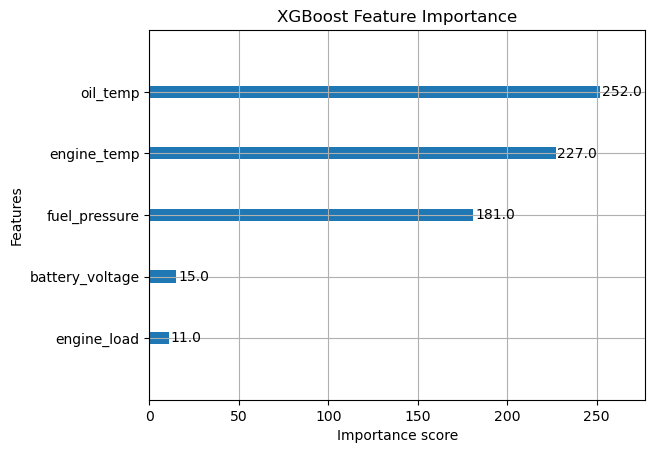

In [27]:
import xgboost as xgb
import matplotlib.pyplot as plt


xgb.plot_importance(best_xgb_model)
plt.title("XGBoost Feature Importance")
plt.show()
